### Initial Setup

Installations, imports, helper functions

In [ ]:
# installs
%%capture

!pip install openai
!pip install transformers
!pip install sentence-transformers

In [ ]:
# imports
import numpy as np
import pandas as pd
import time
import torch
import tqdm
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# upload external file before import
from google.colab import files

import openai
import os
openai.api_key = ""
# os.getenv("OPENAI_API_KEY")

In [ ]:
# Helper functions

def raw_predict(prompt, model = 'text-davinci-002'):
    response = openai.Completion.create(
            model= model, #"text-davinci-002",
            prompt=prompt,
            temperature=0.6,
            max_tokens = 200
        )
    result = response.choices[0].text
    return result

device = torch.device('cuda')

# sentence transformer to compute accuracy between predictions.
sbert_large = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device = device)
def cosine_sim(trues, preds):
    # example:
    # embeddings = sbert.encode(["Walk to home office", "Walk to desk"])
    embeddings_trues = sbert_large.encode(trues)#.cpu()
    embeddings_preds = sbert_large.encode(preds)#.cpu()
    cosine_scores = util.cos_sim(embeddings_trues, embeddings_preds)
    return cosine_scores

# def cosine_sim(trues, preds):
#     sbert = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
#     # example:
#     # embeddings = sbert.encode(["Walk to home office", "Walk to desk"])
#     embeddings_trues = sbert.encode(trues)
#     embeddings_preds = sbert.encode(preds)
#     cosine_scores = util.cos_sim(embeddings_trues, embeddings_preds)
#     return cosine_scores

sbert_small = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device = device) #all-mpnet-base-v2
def cluster(examples, threshold = 0.9, min_cluster_size = 5):
    embeddings = sbert_small.encode(examples, batch_size=64, show_progress_bar=False, convert_to_tensor=True)#.cpu()
    clusters = util.community_detection(embeddings, min_community_size=min_cluster_size, threshold=threshold)
    return clusters, embeddings

# def cluster(examples, threshold = 0.9, min_cluster_size = 5):
#     sbert = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2') #all-mpnet-base-v2
#     embeddings = sbert.encode(examples, batch_size=64, show_progress_bar=True, convert_to_tensor=True)
#     clusters = util.community_detection(embeddings, min_community_size=min_cluster_size, threshold=threshold)
#     return clusters, embeddings

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
# Mount drive to pull the data folder.
from google.colab import drive
drive.mount('/content/drive')
prefix = '/content/drive/MyDrive/fsl-sequential-data-folder' # fsl-sequential

Mounted at /content/drive


In [ ]:
train_data = pd.Series(open(prefix + '/FGR2R_train_prompt.txt').readlines())
val_data = pd.Series(open(prefix + '/FGR2R_validation_prompt.txt').readlines())
test_data = pd.Series(open(prefix + '/FGR2R_test_prompt.txt').readlines())
print(f'Total Data points: TRAIN {len(train_data)} | EVAL {len(val_data)} | TEST {len(test_data)}')

Total Data points: TRAIN 4675 | EVAL 340 | TEST 1391


# Experiments

## GPT-2 Finetuning on the Dataset

In [ ]:
finetune_clusters, embeddings = cluster(train_data, min_cluster_size = 10, threshold = 0.90)
finetune_centroids = torch.stack([torch.mean(embeddings[cluster], axis = 0) for cluster in finetune_clusters])
len(finetune_clusters), len(train_data)

(47, 4675)

In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2') #gpt2-medium # dont set any bos/eos/pad tokens.
tokenizer.pad_token = tokenizer.eos_token
tokenizer

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

PreTrainedTokenizer(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'})

In [ ]:
# init model
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id).to(device) # keep the model unaware of pad tokens. let it be eos tokens.
# model.resize_token_embeddings(len(tokenizer))

**Sample outputs to begin with**

In [ ]:
# turn right and go straight into the large living room=>walk past the table and through the entryway=>walk towards the black table with flower on it

sample_outputs = model.generate(
                    tokenizer(tokenizer.bos_token + " turn right and go straight into the large living room=>", return_tensors = 'pt')['input_ids'].to(device),
                    do_sample=True,   
                    top_k=50, 
                    max_length = 200,
                    top_p=0.95)
print(tokenizer.decode(sample_outputs[0], skip_special_tokens=True))

 turn right and go straight into the large living room=>

I have a couple of other things to say. When I was in college I hated "crap" people (those who say things which are false or not true) and how they were afraid of my friends and family and how I was judged and treated by others. All of that hurt, and yet when I moved to Australia, and started living at home, the feeling got worse for a bit.

What's wrong with people being so afraid of their friends? What's wrong with people being so afraid of their family?

I'm not sure there's a better way to treat your children than being ostracised for talking to them about things which are totally untrue. When I was about six and had to go through the family business in the middle of college, I was really surprised and surprised that everyone around me seemed so comfortable talking to their children. All of a sudden the silence with which I felt I


Works!!

In [ ]:
!nvidia-smi

Fri Dec  9 04:44:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |   2108MiB / 15109MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Data setup

In [ ]:
def generate_similar_support_set(query, clusters, centroids, n_examples = 15, printf = False):
  embeddings = sbert_small.encode(query, batch_size=64, show_progress_bar=False, convert_to_tensor=True)#.cpu()
  
  pick_cluster = torch.argmax(torch.tensordot(centroids, embeddings.unsqueeze(dim = 1), dims = 1).squeeze(), axis = 0).item()

  indices = np.random.choice(clusters[pick_cluster], size = n_examples)
  support_set = train_data.iloc[indices].tolist()
  
  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set[i])
  return support_set

query = "walk down the hallway towards the stair=>walk down the walkway=>go forward down walkway"
support_set = generate_similar_support_set(query, finetune_clusters, finetune_centroids, printf = True)

turn left at the bottom of the stair=>go down the hallway to the right of the stair=>turn left and walk down all of the stair

walk down hallway towards stair=>go straight down the stair=>go down the stair directly ahead

walk down hall up step=>walk down the hallway towards the stair=>walk down the hallway and up the stair

walk down hall up step=>walk down the hallway towards the stair=>walk down the hallway and up the stair

walk up the stair=>turn around and walk up the remain step=>turn around and go right down the hallway

walk down the stair and straight across the hallway=>walk down the hall=>go down the stair



In [ ]:
def generate_training_set(cluster_id, clusters, centroids, n_examples = 15, printf = False):
  indices = np.random.choice(clusters[cluster_id], size = n_examples)
  support_set = train_data.iloc[indices].tolist()

  if printf:
    for i, s in enumerate(support_set):
      if i > 5: break
      print(support_set[i])
  return support_set

In [ ]:
max_length = 768

class GPT2Dataset(Dataset):
  def __init__(self, tokenizer, train, clusters = None, centroids = None, val_data = None, gpt2_type="gpt2", max_length=768):
    self.tokenizer = tokenizer
    self.train = train
    self.val_data = val_data
    self.clusters = clusters
    self.centroids = centroids

  def __len__(self):
    if self.train:
      return len(self.clusters)
    else:
      return len(self.val_data)

  def __getitem__(self, idx):
    cluster_id = np.random.choice(len(self.clusters))

    n_examples = 25
    
    while True:
      if self.train:
        support_examples = generate_training_set(cluster_id, self.clusters, self.centroids, n_examples = n_examples)
      else:
        support_examples = generate_similar_support_set(self.val_data[idx], self.clusters, self.centroids, n_examples = n_examples, printf = False)
      
      prompt = self.tokenizer.bos_token
      query_tokens_length = ''
      for i, example in enumerate(support_examples):
        example_text = example.strip() # '<|startoftext|>'+ example.strip() + '<|endoftext|>'
        if i != len(support_examples)-1:
          example_text += '\n'
        else:
          example_text += self.tokenizer.eos_token
        prompt += example_text
        query_tokens_length = len(self.tokenizer(example_text, truncation = False)['input_ids'])
      
      if len(tokenizer(prompt, truncation = False)['input_ids']) < max_length: 
        break

      n_examples -=1

    encodings_dict = self.tokenizer(prompt, truncation=True, max_length=max_length, padding="max_length")

    input_ids = torch.tensor(encodings_dict['input_ids'], device = device)
    attn_masks = torch.tensor(encodings_dict['attention_mask'], device = device)
    loss_masks = torch.tensor([0.] * (attn_masks.sum() - query_tokens_length) + [1.] * query_tokens_length + [0.] * (len(attn_masks) - attn_masks.sum()), device = device)

    return input_ids, attn_masks, loss_masks

Number of Examples in my clusters

**Training dataset**

Prepared by randomly sampling a cluster ID and then picking some examples that can fit into max size of 768 tokens.

In [ ]:
train_dataset = GPT2Dataset(tokenizer, train = True, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, loss_masks = train_dataset[0]
print(tokenizer.decode(input_ids))

<|endoftext|>exit the closet=>leave the closet=>you be in a closet
exit the room=>exit the room=>walk out of the closet
exit the closet=>exit door=>exit the closet
walk out of the closet=>exit the closet=>leave the room
exit the closet=>leave the closet=>you be in a closet
walk through the doorway to exit the closet=>exit the room=>exit the pantry
exit the closet=>leave the closet=>you be in a closet
exit the closet=>exit door=>exit the closet
exit the room=>exit the room=>walk out of the closet
exit the closet=>exit the closet=>turn right to exit the bathroom
exit the closet=>exit the closet=>exit the nice closet
exit the closet=>turn around and exit the closet=>walk out of the closet
exit the closet=>exit the closet=>turn right to exit the bathroom
exit the closet=>exit the closet=>turn right to exit the bathroom
exit the room=>exit the room=>walk out of the closet
exit the room=>exit the room=>walk out of the closet
exit the closet=>leave the laundry room=>leave the closet
exit the 

In [ ]:
tokenizer.decode(input_ids[loss_masks==1])

'walk out of the closet=>exit the closet=>leave the room<|endoftext|>'

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


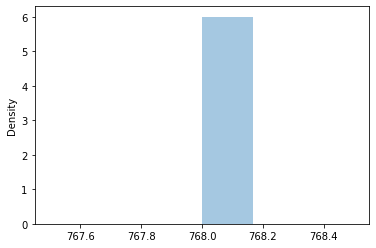

In [ ]:
doc_lengths = []

for i in range(len(finetune_clusters)):
    input_ids, attn_masks, loss_masks = train_dataset[i]

    # prompt_text = tokenizer.decode(input_ids)

    # get rough token count distribution
    # tokens = nltk.word_tokenize(prompt_text)

    doc_lengths.append(len(input_ids))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

**Validation dataset**

Go through the validation set query and match them with similar training examples. Obtain each data instance as prompt of that query alongwith examples from training set.

In [ ]:
val_dataset = GPT2Dataset(tokenizer, train = False, val_data = val_data, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, val_loss_masks = val_dataset[0]
print(tokenizer.decode(input_ids))

<|endoftext|>walk out of the bedroom=>turn right and go through the door=>exit the room through the door
after you leave the bedroom you should go the bedroom at the end of the hall=>walk into the hallway=>exit the bedroom on the right
exit the bedroom=>exit the bedroom on the right=>walk straight out the door ahead
leave the bedroom turn left=>turn to the right=>walk through the bedroom and out through the open door into the hallway
exit the bedroom=>leave the bedroom=>walk around the bed a go out the bedroom door
turn around and exit the room=>walk through the bedroom past the bed and closet and out through the open door on the other side=>leave the bedroom
exit the room=>exit the bedroom=>turn around and walk out of the bedroom and into the hallway
exit the room into the hallway=>exit the bedroom and turn right=>exit the bedroom
exit the bedroom=>exit the bedroom and turn left=>exit the room
turn around and exit the room out the last door on your right=>exit the bedroom=>turn around

#### Dataloaders

In [ ]:
print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

batch_size = 2
val_batch_size = 10
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

   47 training samples
  340 validation samples


In [ ]:
next(iter(train_dataloader))[0].device

device(type='cuda', index=0)

**Fine-tuning GPT2**

### Model configuration

Reference [notebook](https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh#scrollTo=D6TKgyUzPIQc)

In [ ]:
# # I'm not really doing anything with the config buheret
# configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# # instantiate the model
# model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# # this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# # otherwise the tokenizer and model tensors won't match up
# # model.resize_token_embeddings(len(tokenizer))

# # Tell pytorch to run this model on the GPU.
# device = torch.device("cuda")
# model.cuda()

### Linear Probing/Finetuning

In [ ]:
lp = True
file_name = prefix + '/vln_lp_dec14.pth'

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
for p in model.parameters(): p.requires_grad_((not lp))
# only turn on linear probing for the LM head.
for p in model.lm_head.parameters(): p.requires_grad_(True)

In [ ]:
print('Total trainable parameters :', int(count_parameters(model)/1e6), 'M')

Total trainable parameters : 38 M


### Initialize parameters

In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# some parameters I cooked up that work reasonably well

epochs = 40
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 20

epoch_start = 0
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

if Path(file_name).exists():
  dict_ = torch.load(file_name)
  epoch_start = dict_['epoch']
  model.load_state_dict(dict_['model'])
  optimizer.load_state_dict(dict_['optimizer'])
  scheduler.load_state_dict(dict_['scheduler'])

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# paste the training stats here
# result = {
#   'epoch': 40,
#   'training_stats': training_stats,
#   'model': model.state_dict(),
#   'optimizer': optimizer.state_dict(),
#   'scheduler': scheduler.state_dict()
# }

# torch.save(result, file_name)

In [ ]:
!nvidia-smi

Thu Dec 15 01:51:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   7806MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Training**

In [ ]:
model = model.to(device)

Sanity tests ahead of the real one.

In [ ]:
batch = next(iter(train_dataloader))

b_input_ids = batch[0].to(device)
b_labels = torch.clone(batch[0]).to(device)
b_masks = batch[1].to(device)
b_loss_masks = batch[2].to(device)

b_labels[b_loss_masks==0] = -100

outputs = model(b_input_ids,
                labels=b_labels, 
                attention_mask = b_masks,
                token_type_ids=None
              )

All set !

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

accumulation_steps = 2

for epoch_i in range(epoch_start, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    train_nlls = []
    train_tokens_len = []
    
    for step, batch in enumerate(train_dataloader):
        model.train()
        model.zero_grad()

        b_input_ids = batch[0].to(device)
        b_labels = torch.clone(batch[0]).to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        # b_labels[b_loss_masks==0] = -100


        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        
        loss = outputs[0]
        batch_loss = loss.item()
        total_train_loss += batch_loss

        tokens_len = b_loss_masks.sum()
        neg_log_likelihood = batch_loss * tokens_len
        train_nlls.append(neg_log_likelihood)
        train_tokens_len.append(tokens_len)
    
        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                tokenizer(tokenizer.bos_token + " Walk to office =>", return_tensors = 'pt')['input_ids'].to(device),
                                do_sample=True,   
                                temperature = 0.6,
                                no_repeat_ngram_size=2,
                                top_k=50, 
                                max_length = 50,
                                top_p=0.95,
                                num_return_sequences = 1
                              )
            
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)
    
    # Train perplexity
    train_pp = torch.exp(torch.stack(train_nlls).sum() / sum(train_tokens_len)).item()
    
    # Measure how long this epoch took.
    training_time_taken= time.time() - t0
    training_time = format_time(training_time_taken)

    print("")
    print("  Average training loss: {:.2f} Perplexity: {:.2f}".format(avg_train_loss, train_pp))
    print("  Training epoch took: {:}".format(training_time))

    # continue
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0
    val_loss = 0

    # Evaluate data for one epoch
    val_nlls = []
    val_tokens_len = []
    for batch in tqdm.tqdm(validation_dataloader, total = len(validation_dataloader)):
        b_input_ids = batch[0].to(device)
        b_labels = torch.clone(batch[0]).to(device)
        b_masks = batch[1].to(device)
        b_loss_masks = batch[2].to(device)

        # b_labels[b_loss_masks==0] = -100
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
                          #  token_type_ids=None, 
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
        
        batch_loss = loss.item()
        total_eval_loss += batch_loss  

        tokens_len = b_loss_masks.sum()
        neg_log_likelihood = batch_loss * tokens_len
        val_nlls.append(neg_log_likelihood)
        val_tokens_len.append(tokens_len)

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    val_pp = torch.exp(torch.stack(val_nlls).sum() / sum(val_tokens_len)).item()
    validation_time_taken = time.time() - t0
    validation_time = format_time(validation_time_taken)

    print("  Validation Loss: {:.2f} Perplexity: {:.2f}".format(avg_val_loss, val_pp))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append({
      'training_loss': avg_train_loss,
      'training_perplexity': train_pp,
      'validation_loss': avg_val_loss,
      'validation_perplexity': val_pp,
      'training_time': training_time_taken,
      'validation_time': validation_time_taken
    })

    result = {
      'epoch': epoch_i + 1,
      'training_stats': training_stats,
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'scheduler': scheduler.state_dict()
    }

    torch.save(result, file_name)

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 40 ========
Training...
  Batch    20  of     24. Loss: 4.349465370178223.   Elapsed: 0:00:08.
0:  Walk to office =>

A. Walk through the office
.
 and then walk to the next office and walk through to that office. B. Tell the employee you want to go to. C. Bring the paperwork you need. D

  Average training loss: 4.88 Perplexity: 121.12
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:32<00:00,  5.29it/s]


  Validation Loss: 4.12 Perplexity: 54.72
  Validation took: 0:00:32

======== Epoch 2 / 40 ========
Training...
  Batch    20  of     24. Loss: 3.7262539863586426.   Elapsed: 0:00:09.
0:  Walk to office => Office

Office

  Average training loss: 3.67 Perplexity: 37.98
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:35<00:00,  4.78it/s]


  Validation Loss: 2.61 Perplexity: 13.11
  Validation took: 0:00:36

======== Epoch 3 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.2200281620025635.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 1.97 Perplexity: 7.23
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 1.07 Perplexity: 2.98
  Validation took: 0:00:33

======== Epoch 4 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.000862717628479.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 1.16 Perplexity: 3.22
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.91 Perplexity: 2.54
  Validation took: 0:00:34

======== Epoch 5 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.2815576791763306.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 1.03 Perplexity: 2.84
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.88 Perplexity: 2.46
  Validation took: 0:00:34

======== Epoch 6 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.7299116253852844.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 1.01 Perplexity: 2.80
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.01it/s]


  Validation Loss: 0.87 Perplexity: 2.44
  Validation took: 0:00:34

======== Epoch 7 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.8066194653511047.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.92 Perplexity: 2.56
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.85 Perplexity: 2.39
  Validation took: 0:00:34

======== Epoch 8 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.1155180931091309.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.97 Perplexity: 2.65
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.84 Perplexity: 2.37
  Validation took: 0:00:34

======== Epoch 9 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.0393898487091064.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.91 Perplexity: 2.57
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.83 Perplexity: 2.35
  Validation took: 0:00:33

======== Epoch 10 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.8617760539054871.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.89 Perplexity: 2.49
  Training epoch took: 0:00:11

Running Validation...


100%|██████████| 170/170 [00:34<00:00,  4.99it/s]


  Validation Loss: 0.82 Perplexity: 2.32
  Validation took: 0:00:34

======== Epoch 11 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.5765516757965088.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.86 Perplexity: 2.42
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.82 Perplexity: 2.31
  Validation took: 0:00:34

======== Epoch 12 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.7124799489974976.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.87 Perplexity: 2.42
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.81 Perplexity: 2.30
  Validation took: 0:00:34

======== Epoch 13 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.8922750353813171.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.82 Perplexity: 2.30
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.80 Perplexity: 2.27
  Validation took: 0:00:33

======== Epoch 14 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.8946346044540405.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.87 Perplexity: 2.44
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:34<00:00,  4.93it/s]


  Validation Loss: 0.80 Perplexity: 2.25
  Validation took: 0:00:34

======== Epoch 15 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.0944533348083496.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.86 Perplexity: 2.45
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.79 Perplexity: 2.25
  Validation took: 0:00:33

======== Epoch 16 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.5497053861618042.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.86 Perplexity: 2.41
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.79 Perplexity: 2.24
  Validation took: 0:00:34

======== Epoch 17 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.6686375141143799.   Elapsed: 0:00:09.
0:  Walk to office => go to the nearest open floorwalk to your right and exit the hall to go down the hallway to open the door on the left


  Average training loss: 0.83 Perplexity: 2.38
  Training epoch took: 0:00:11

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.78 Perplexity: 2.23
  Validation took: 0:00:33

======== Epoch 18 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.7140103578567505.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.79 Perplexity: 2.23
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:34<00:00,  4.99it/s]


  Validation Loss: 0.78 Perplexity: 2.22
  Validation took: 0:00:34

======== Epoch 19 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.7696153521537781.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.81 Perplexity: 2.30
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.05it/s]


  Validation Loss: 0.77 Perplexity: 2.21
  Validation took: 0:00:34

======== Epoch 20 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.0759931802749634.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.84 Perplexity: 2.37
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.77 Perplexity: 2.21
  Validation took: 0:00:33

======== Epoch 21 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.9476194977760315.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.81 Perplexity: 2.30
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.09it/s]


  Validation Loss: 0.76 Perplexity: 2.18
  Validation took: 0:00:33

======== Epoch 22 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.9271807074546814.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.76 Perplexity: 2.18
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.76 Perplexity: 2.18
  Validation took: 0:00:34

======== Epoch 23 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.5899116396903992.   Elapsed: 0:00:09.
0:  Walk to office => turn left
walk to your left=>turn right


  Average training loss: 0.81 Perplexity: 2.28
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.06it/s]


  Validation Loss: 0.76 Perplexity: 2.18
  Validation took: 0:00:34

======== Epoch 24 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.750541090965271.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.81 Perplexity: 2.27
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.75 Perplexity: 2.17
  Validation took: 0:00:34

======== Epoch 25 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.744373083114624.   Elapsed: 0:00:09.
0:  Walk to office =>


  Average training loss: 0.75 Perplexity: 2.15
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.06it/s]


  Validation Loss: 0.76 Perplexity: 2.18
  Validation took: 0:00:34

======== Epoch 26 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.7110246419906616.   Elapsed: 0:00:09.
0:  Walk to office =>
exit the door
walk to the right
turn left
leave the stairwell
go straight ahead
move forward
stand at the doorway
start the elevator
enter the hallway
continue forward and exit the room


  Average training loss: 0.75 Perplexity: 2.18
  Training epoch took: 0:00:11

Running Validation...


100%|██████████| 170/170 [00:35<00:00,  4.86it/s]


  Validation Loss: 0.75 Perplexity: 2.16
  Validation took: 0:00:35

======== Epoch 27 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.7005781531333923.   Elapsed: 0:00:09.
0:  Walk to office =>
exit the room

  Average training loss: 0.79 Perplexity: 2.26
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.05it/s]


  Validation Loss: 0.75 Perplexity: 2.17
  Validation took: 0:00:34

======== Epoch 28 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.8417977690696716.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.78 Perplexity: 2.18
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.75 Perplexity: 2.16
  Validation took: 0:00:34

======== Epoch 29 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.5426472425460815.   Elapsed: 0:00:09.
0:  Walk to office => turn right
walk to your right

  Average training loss: 0.83 Perplexity: 2.37
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.75 Perplexity: 2.15
  Validation took: 0:00:33

======== Epoch 30 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.8505148887634277.   Elapsed: 0:00:09.
0:  Walk to office =>
exit the room


  Average training loss: 0.76 Perplexity: 2.16
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.11it/s]


  Validation Loss: 0.75 Perplexity: 2.16
  Validation took: 0:00:33

======== Epoch 31 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.0606913566589355.   Elapsed: 0:00:09.
0:  Walk to office => go to the foot of the stair and walk to your left


  Average training loss: 0.77 Perplexity: 2.19
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.06it/s]


  Validation Loss: 0.74 Perplexity: 2.14
  Validation took: 0:00:34

======== Epoch 32 / 40 ========
Training...
  Batch    20  of     24. Loss: 1.2200589179992676.   Elapsed: 0:00:09.
0:  Walk to office =>
walk to the door


  Average training loss: 0.77 Perplexity: 2.20
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.09it/s]


  Validation Loss: 0.74 Perplexity: 2.14
  Validation took: 0:00:33

======== Epoch 33 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.7175910472869873.   Elapsed: 0:00:09.
0:  Walk to office =>
go to the walk to room
walk to bathroom


  Average training loss: 0.77 Perplexity: 2.22
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.08it/s]


  Validation Loss: 0.74 Perplexity: 2.14
  Validation took: 0:00:34

======== Epoch 34 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.8647499680519104.   Elapsed: 0:00:09.
0:  Walk to office =>
exit


  Average training loss: 0.76 Perplexity: 2.19
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.74 Perplexity: 2.13
  Validation took: 0:00:34

======== Epoch 35 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.9936668872833252.   Elapsed: 0:00:09.
0:  Walk to office => go to the door
exit the room
walk to hallway
go straight down the hall
leave the hallway through the open door on the left
turn around and go straight into the elevator
take a right to your right

  Average training loss: 0.77 Perplexity: 2.19
  Training epoch took: 0:00:11

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.74 Perplexity: 2.13
  Validation took: 0:00:34

======== Epoch 36 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.9099118709564209.   Elapsed: 0:00:09.
0:  Walk to office =>
exit the hallway
walk to hallway to exit the hall


  Average training loss: 0.83 Perplexity: 2.32
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.06it/s]


  Validation Loss: 0.74 Perplexity: 2.12
  Validation took: 0:00:34

======== Epoch 37 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.9227200746536255.   Elapsed: 0:00:09.
0:  Walk to office =>
exit the elevator
walk to the adjacent stair


  Average training loss: 0.75 Perplexity: 2.15
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.10it/s]


  Validation Loss: 0.74 Perplexity: 2.13
  Validation took: 0:00:33

======== Epoch 38 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.5550288558006287.   Elapsed: 0:00:09.
0:  Walk to office =>

  Average training loss: 0.73 Perplexity: 2.12
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.73 Perplexity: 2.11
  Validation took: 0:00:34

======== Epoch 39 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.689375638961792.   Elapsed: 0:00:09.
0:  Walk to office =>
walk to the door


  Average training loss: 0.75 Perplexity: 2.16
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.02it/s]


  Validation Loss: 0.74 Perplexity: 2.12
  Validation took: 0:00:34

======== Epoch 40 / 40 ========
Training...
  Batch    20  of     24. Loss: 0.9581400752067566.   Elapsed: 0:00:09.
0:  Walk to office => go

  Average training loss: 0.70 Perplexity: 2.03
  Training epoch took: 0:00:10

Running Validation...


100%|██████████| 170/170 [00:33<00:00,  5.07it/s]


  Validation Loss: 0.74 Perplexity: 2.13
  Validation took: 0:00:34

Training complete!
Total training took 0:31:27 (h:mm:ss)


#### Training statistics

Note: Choice of similarity function matters a lot.

---


Save trained model. (happens during training itself)

In [ ]:
def plot(x, y1, y2, ymin = 0, ymax = 1, c1 = 'darkviolet', c2 = 'red', ylabel = 'Entropy loss'):
    plt.figure(dpi = 150)
    plt.plot(x, y1, label = 'Training', marker = '.', markersize = 5, linewidth = 2, c = c1)
    plt.plot(x, y2, label = 'Validation', marker = '.', markersize = 5, linewidth = 2, c = c2)
    plt.ylim(ymin, ymax)
    plt.xlabel('Epochs', fontsize = 15)
    plt.ylabel(ylabel , fontsize = 15)
    plt.legend(fontsize = 15)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)

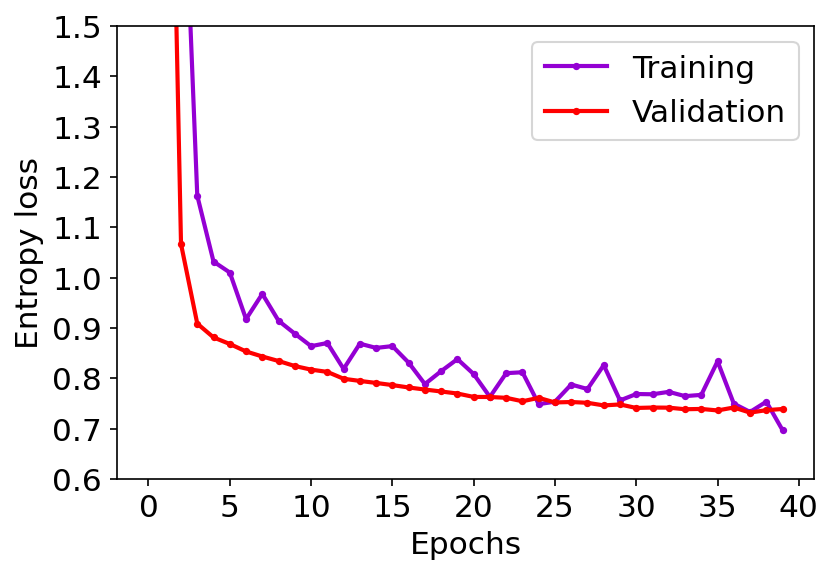

In [ ]:
epochs = list(range(len(training_stats)))
y1 = [i['training_loss'] for i in training_stats]
y2 = [i['validation_loss'] for i in training_stats]

plot(epochs, y1, y2, ymin = 0.6, ymax = 1.5, ylabel = 'Entropy loss')

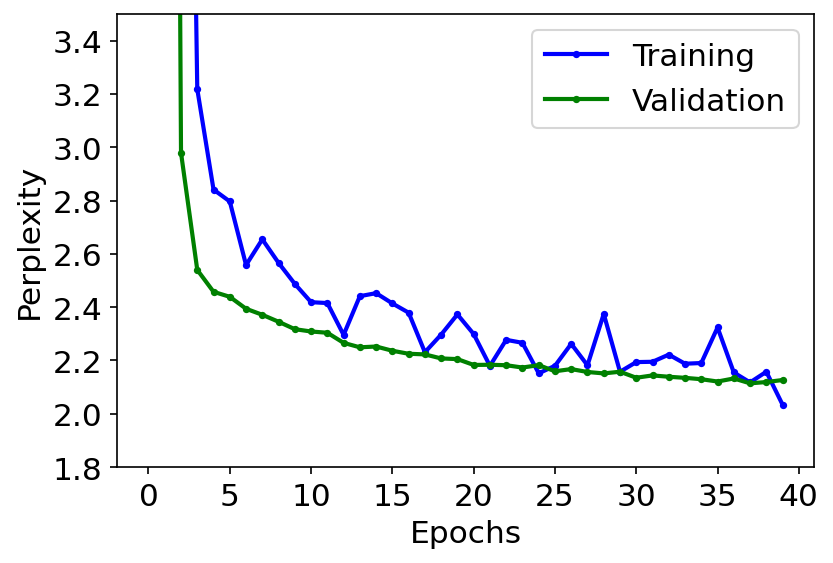

In [ ]:
epochs = list(range(len(training_stats)))
y1 = [i['training_perplexity'] for i in training_stats]
y2 = [i['validation_perplexity'] for i in training_stats]

plot(epochs, y1, y2, c1 = 'blue', c2= 'green', ymin = 1.8, ymax = 3.5, ylabel = 'Perplexity')

In [ ]:
training_time = [i['training_time'] for i in training_stats]
validation_time = [i['validation_time'] for i in training_stats]
print('Average Training time: {}s, Average Validation time: {}s'.format(np.mean(training_time), np.mean(validation_time)))
print('Total Training time: {}m, Total Validation time: {}m'.format(np.sum(training_time)//60, np.sum(validation_time)//60))

Average Training time: 10.297775846719741s, Average Validation time: 33.65490857362747s
Total Training time: 6.0m, Total Validation time: 22.0m


In [ ]:
# torch.save(model.state_dict(), file_name)

# # download checkpoint file
# files.download(file_name)

### Testing

Load back the trained model and all the training stats.

In [ ]:
if Path(file_name).exists():
  dict_ = torch.load(file_name)
  model.load_state_dict(dict_['model'])
  training_stats = dict_['training_stats']

In [ ]:
test_dataset = GPT2Dataset(tokenizer, train = False, val_data = test_data, clusters = finetune_clusters, centroids = finetune_centroids)
input_ids, attn_masks, val_loss_masks = val_dataset[0]
print(tokenizer.decode(input_ids))

<|endoftext|>exit the bedroom=>exit the room use the doorway and open door to your left=>go through the door on the left
enter the doorway=>exit the bedroom=>leave the bedroom
go straight to exit the room=>with the bed to your immediate left walk forward to exit the bedroom=>turn right and exit the room
after you leave the bedroom you should go the bedroom at the end of the hall=>walk into the hallway=>exit the bedroom on the right
after you leave the bedroom make a left in the hallway=>exit the bedroom=>go around the bed and to the door
enter the doorway=>exit the bedroom=>leave the bedroom
exit the room and turn right=>exit bedroom turn right=>go to the door
exit the room=>leave the bedroom=>turn around then turn right
exit the bedroom=>exit the room then turn right=>turn left and go forward a few step
exit the bedroom=>walk out of the bedroom and through the entryway across the hall=>exit the room use the door on the right then
walk out of the bedroom=>turn right and go through the 

Utility for decoding GPT-2 predictions

In [ ]:
def gpt2_predict(prompt):
  # prompt = "<|endoftext|> Walk to bedroom=>Walk to floor =>"
  sample_outputs = model.generate(
                          tokenizer(prompt, return_tensors='pt')['input_ids'].cuda(),
                          bos_token_id = tokenizer.bos_token_id, #random.randint(1,30000),
                          eos_token_id = tokenizer.eos_token_id,
                          pad_token_id = tokenizer.pad_token_id,
                          do_sample=True,   
                          # temperature = 0.5,
                          # top_k=50, 
                          max_length = 100,
                          # top_p=0.95, 
                          num_return_sequences=1
                      )
  outputs = tokenizer.decode(sample_outputs[0])
  # print('outputs:', outputs)
  return outputs[len(prompt):]

In [ ]:
preds = []
trues = []

test_nlls = []
test_tokens_len = []
test_times = []

separator = '=>'

for index, val_data in tqdm.tqdm(enumerate(test_dataset), total = len(test_dataset)-1): # Fix range

  if index == 100: break

  input_ids, attn_masks, val_loss_masks = val_data
  entire_example = tokenizer.decode(input_ids).split('<|endoftext|>')[1]

  example_split = entire_example.split('\n')
  support_set = '\n'.join(example_split[:-1])
  splits = example_split[-1].split(separator)

  # code for perplexity and nll loss.
  model.train()
  encodings_dict = tokenizer(query, return_tensors = 'pt').to(device)
  outputs = model(encodings_dict['input_ids'], labels = encodings_dict['input_ids'])
  loss = outputs[0]
  len_ = encodings_dict['attention_mask'].sum()
  test_nlls.append(loss.item() * len_)
  test_tokens_len.append(len_)
  model.eval()

  time_step = np.random.randint(1, len(splits)) #len(splits)-1)

  t0 = time.time()

  for time_step in range(1, len(splits)-1):

    query = separator.join([text for text in splits[:time_step]])

    prompt = f'''<|endoftext|>{separator.join([text for text in splits[:time_step]])}=>''' #{support_set}

    # print(prompt)
    # print('####'* 10)

    result = gpt2_predict(prompt)
    # print('result:', result)
    pred = result.strip().split('\n')[0].split(separator)[0].strip()
    preds.append(pred)
    trues.append(splits[time_step])

    if index <= 1:
      print(query + '=>' + pred + '\n')
    
    t1 = time.time()
    
    test_times.append(t1 - t0)

  0%|          | 1/1390 [00:00<06:54,  3.35it/s]

walk down the hallway=>walk down the hallway



  0%|          | 3/1390 [00:00<04:48,  4.81it/s]

enter the kitchen=>leave the bathroom



  7%|▋         | 100/1390 [01:03<13:33,  1.59it/s]


In [ ]:
trues = np.array(trues); preds = np.array(preds)
res = cosine_sim(trues, preds)
res = torch.stack([res[i][i] for i in range(len(res))])
correct = res> 0.5
acc = correct.sum() / len(res)
cos_sim = res.sum() / len(res)

avg_test_entropy = torch.stack(test_nlls).sum() / sum(test_tokens_len)
test_pp = torch.exp(avg_test_entropy)

df = pd.DataFrame({
    'Actual': trues,
    'Predicted': preds,
    'Cosine Sim': res,
    'Correct/not': correct
})

# Train perplexity

print(f'Accuracy is: {acc * 100}%')
print(f'Perplexity is: {test_pp}')
print(f'Avg Loss is: {avg_test_entropy}')
print(f'Cosine Similarity is: {df["Cosine Sim"].mean()}')

df

Accuracy is: 50.0%
Perplexity is: 17.858701705932617
Avg Loss is: 2.882490873336792
Cosine Similarity is: 0.49980685114860535


,Actual,Predicted,Cosine Sim,Correct/not
0,turn around and walk down the hall to the room...,walk down the hallway,0.724059,True
1,walk between the kitchen counter and dining table,leave the bathroom,0.322551,False
2,walk out the door into the hallway,with right,0.240598,False
3,walk forward to the end of the hallway,turn right,0.414883,False
4,turn right and walk across the hall,exit,0.336380,False
...,...,...,...,...
95,turn around and go down the hallway,walk down the entire hallway,0.757633,True
96,walk between the two table,<|endoftext|>,0.072864,False
97,exit bedroom door,turn right to leave the bedroom,0.657366,True
98,walk to the opposite side of bed,turn around and around,0.436434,False


Make it predict random stuff.

In [ ]:
model.eval()

prompt = "<|startoftext|> Walk to bedroom=>Walk to floor =>"
sample_outputs = model.generate(
                        tokenizer(prompt, return_tensors='pt')['input_ids'].cuda(),
                        bos_token_id = tokenizer.bos_token_id, #random.randint(1,30000),
                        eos_token_id = tokenizer.eos_token_id,
                        pad_token_id = tokenizer.pad_token_id,
                        do_sample=True,   
                        # temperature = 0.5,
                        # top_k=50, 
                        max_length = 30,
                        # top_p=0.95, 
                        num_return_sequences=1
                    )
outputs = tokenizer.decode(sample_outputs[0])
outputs[len(prompt):].split(separator)

['turn around and walk out of the bedroom and into the hallway\nwalk down']